In [93]:
class Player:
    def __init__(self, name, position, offense, defense, stamina, speed, iq, usage, rebounding):
        self.name = name
        self.position = position
        self.offense = offense
        self.defense = defense
        self.stamina = stamina
        self.speed = speed
        self.iq = iq
        self.usage = usage
        self.confidence = 1.0
        self.rebounding = rebounding
        
        self.points = 0
        self.shots_made = 0
        self.shots_attempted = 0
        self.assists = 0
        self.offRebounds = 0
        self.defRebounds = 0
        self.totalRebounds = 0

    def adjust_attributes(self, matchup_effect):
        self.offense += matchup_effect['offense']
        self.defense += matchup_effect['defense']

class Team:
    def __init__(self, name, players):
        self.name = name
        self.players = players
        self.strategy = 'balanced'

    def adjust_strategy(self, new_strategy):
        self.strategy = new_strategy


In [94]:
def calculate_matchup_effect(offensive_player, defensive_player):
    offense_effect = offensive_player.offense - defensive_player.defense
    defense_effect = defensive_player.defense - offensive_player.offense
    return {'offense': offense_effect, 'defense': defense_effect}

def apply_matchup_effects(offensive_team, defensive_team):
    for player in offensive_team.players:
        for opponent in defensive_team.players:
            if player.position == opponent.position:
                effect = calculate_matchup_effect(player, opponent)
                player.adjust_attributes(effect)

In [97]:
# Cell 3
import random

def generate_outcomes(players):
    outcomes = []
    for player in players:
        outcomes.extend([
            (f'{player.name} 3pt', player),
            (f'{player.name} Midrange', player),
            (f'{player.name} Inside', player)
        ])
    return outcomes

def get_success_rate(player, outcome):
    if '3pt' in outcome:
        return player.offense
    elif 'Midrange' in outcome:
        return player.offense
    elif 'Inside' in outcome:
        return player.offense
    return 0

def get_rebounding_synergy(team):
    totalRebounding = 0
    for player in team.players:
        totalRebounding += player.rebounding
    return totalRebounding

def choose_rebounder(team):
    weights = [player.rebounding for player in team.players]
    chosen_player = random.choices(team.players, weights=weights, k=1)[0]
    return chosen_player

def simulate_rebound(offensiveTeam, defensiveTeam, play_by_play):
    offRebounding = get_rebounding_synergy(offensiveTeam)
    defRebounding = get_rebounding_synergy(defensiveTeam)
    offReboundingProbability = (offRebounding*0.25)/ (offRebounding+defRebounding)
    if random.random() < offReboundingProbability:
        rebounder = choose_rebounder(offensiveTeam)
        rebounder.offRebounds += 1
        rebounder.totalRebounds += 1
        play_by_play.append(f"{rebounder.name} grabs the offensive rebound.")
        return offensiveTeam, defensiveTeam
        
    else:
        rebounder = choose_rebounder(defensiveTeam)
        rebounder.defRebounds += 1
        rebounder.totalRebounds += 1
        play_by_play.append(f"{rebounder.name} grabs the defensive rebound.")
        return defensiveTeam, offensiveTeam


def simulate_possession(offensive_team, defensive_team, play_by_play):
    # Generate outcomes dynamically based on the players in the team
    outcomes = generate_outcomes(offensive_team.players)
    
    # Select key decision maker based on usage probability
    decision_maker = random.choices(offensive_team.players, weights=[p.usage for p in offensive_team.players], k=1)[0]
    
    
    # Adjust the weights based on the decision maker's IQ
    outcome_weights = []
    for outcome, player in outcomes:
        success_rate = get_success_rate(player, outcome)
        base_weight = 1  # Each outcome starts with an equal base weight
        if decision_maker.iq > 75:
            weight = base_weight * (1 + success_rate)  # Higher IQ favors more successful outcomes
        else:
            weight = base_weight  # Lower IQ keeps the weight distribution more even
        outcome_weights.append(weight)
    
    selected_outcome, selected_player = random.choices(outcomes, weights=outcome_weights, k=1)[0]
    
    # Success check based on matchup and player attributes
    primary_defender = next(p for p in defensive_team.players if p.position == selected_player.position)
    success_probability = (get_success_rate(selected_player, selected_outcome) / 
                           (get_success_rate(selected_player, selected_outcome) + primary_defender.defense))
    

    selected_player.shots_attempted += 1
    if random.random() < success_probability:
        result = 'made'
        selected_player.shots_made += 1
        decision_maker.assists += 1
        if '3pt' in selected_outcome:
            selected_player.points += 3
        else:
            selected_player.points += 2
        possession = defensive_team, offensive_team
    else:
        result = 'missed'
    
    # Add to play-by-play
    if (decision_maker == selected_player or result == 'missed'):
        play_by_play.append(f"{selected_outcome} and {result}.")

    elif (result == 'made'):
        play_by_play.append(f"{selected_outcome} and {result} Ast. {decision_maker.name}")
        possession = defensive_team, offensive_team
        
    if (result == 'missed'):
        possession = simulate_rebound(offensive_team, defensive_team, play_by_play)
    
    return selected_outcome, result, possession

def simulate_game(team1, team2, possessions):
    team1_score = 0
    team2_score = 0
    play_by_play = []

    outcome, result, possession = simulate_possession(team1, team2, play_by_play)
    
    for i in range(possessions-1):
        offensiveTeam = possession[0]
        defensiveTeam = possession[1]
        outcome, result, possession = simulate_possession(offensiveTeam, defensiveTeam, play_by_play)
        if result == 'made':
            if '3pt' in outcome:
                if (offensiveTeam == team1): team1_score += 3
                else: team2_score += 3
            elif 'Midrange' in outcome or 'Inside' in outcome:
                if (offensiveTeam == team1): team1_score += 2
                else: team2_score += 2
            play_by_play.append(f"{team1_score}-{team2_score}")
                
    return team1_score, team2_score, play_by_play

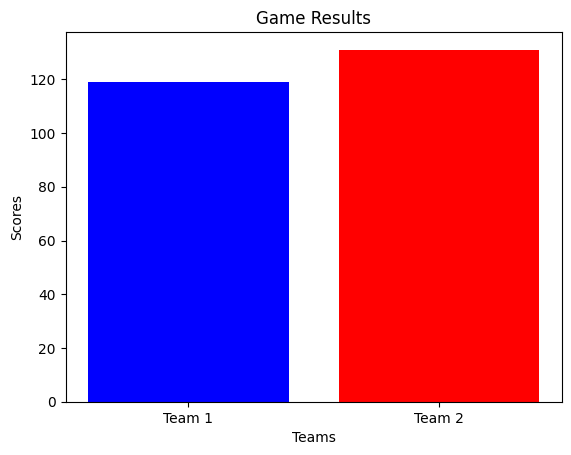

Kyrie Midrange and made.
Player 6 Inside and made.
0-2
Kyrie Midrange and made.
2-2
Player 8 3pt and made Ast. Player 6
2-5
Dirk Midrange and made Ast. Luka
4-5
Player 7 3pt and missed.
Luka grabs the defensive rebound.
THJ Midrange and missed.
Player 9 grabs the defensive rebound.
Player 10 Inside and made Ast. Player 9
4-7
Kyrie 3pt and made Ast. THJ
7-7
Player 7 3pt and missed.
Dirk grabs the defensive rebound.
THJ Midrange and missed.
Player 6 grabs the defensive rebound.
Player 6 3pt and missed.
Dirk grabs the defensive rebound.
THJ 3pt and made Ast. Dirk
10-7
Player 6 Inside and missed.
Lively grabs the defensive rebound.
THJ Inside and made Ast. Luka
12-7
Player 9 Midrange and missed.
Lively grabs the defensive rebound.
Dirk Inside and made Ast. THJ
14-7
Player 10 Inside and made Ast. Player 8
14-9
Dirk Midrange and missed.
Player 9 grabs the defensive rebound.
Player 6 3pt and missed.
Lively grabs the defensive rebound.
Kyrie Midrange and missed.
Player 9 grabs the defensive re

In [98]:
import matplotlib.pyplot as plt

def plot_game_results(team1_score, team2_score):
    labels = ['Team 1', 'Team 2']
    scores = [team1_score, team2_score]
    plt.bar(labels, scores, color=['blue', 'red'])
    plt.xlabel('Teams')
    plt.ylabel('Scores')
    plt.title('Game Results')
    plt.show()

def display_box_score(team):
    print(f"Box Score for {team.name}:")
    for player in team.players:
        print(f"{player.name} - Points: {player.points}, Assists: {player.assists}, "
              f"Shots Made: {player.shots_made}, Shots Attempted: {player.shots_attempted}, "
              f"DRebs: {player.defRebounds}, ORebs: {player.offRebounds}")

# Example usage
team1_players = [
    Player('Kyrie', 'PG', 80, 70, 90, 80, 85, 20, 25),
    Player('Luka', 'SG', 75, 65, 85, 75, 80, 30, 35),
    Player('THJ', 'SF', 78, 72, 88, 78, 82, 25, 45),
    Player('Lively', 'PF', 74, 68, 84, 76, 79, 15, 55),
    Player('Dirk', 'C', 82, 75, 86, 79, 81, 10, 65)
]

team2_players = [
    Player('Player 6', 'PG', 78, 72, 88, 78, 82, 25, 25),
    Player('Player 7', 'SG', 74, 68, 84, 76, 79, 28, 35),
    Player('Player 8', 'SF', 76, 71, 85, 77, 80, 22, 55),
    Player('Player 9', 'PF', 73, 67, 83, 75, 78, 18, 65),
    Player('Player 10', 'C', 81, 74, 87, 80, 83, 15, 85)
]

team1 = Team('Team 1', team1_players)
team2 = Team('Team 2', team2_players)

team1_score, team2_score, play_by_play = simulate_game(team1, team2, 200)
plot_game_results(team1_score, team2_score)

# Display play-by-play
for play in play_by_play:
    print(play)

# Display box scores
display_box_score(team1)
display_box_score(team2)


In [99]:
#pip install notebook
